In [1]:
import json
import os

In [10]:
def read_json_file(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

training_challenges_file_path = "data/arc-agi_training_challenges.json"
training_challenges = read_json_file(training_challenges_file_path)

training_solutions_file_path = "data/arc-agi_training_solutions.json"
training_solutions = read_json_file(training_solutions_file_path)

In [11]:
print(training_challenges.keys())
print(training_challenges.get("007bbfb7"))
print(training_solutions.get("007bbfb7"))

dict_keys(['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c', '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7', '09629e4f', '0962bcdd', '0a938d79', '0b148d64', '0ca9ddb6', '0d3d703e', '0dfd9992', '0e206a2e', '10fcaaa3', '11852cab', '1190e5a7', '137eaa0f', '150deff5', '178fcbfb', '1a07d186', '1b2d62fb', '1b60fb0c', '1bfc4729', '1c786137', '1caeab9d', '1cf80156', '1e0a9b12', '1e32b0e9', '1f0c79e5', '1f642eb9', '1f85a75f', '1f876c06', '1fad071e', '2013d3e2', '2204b7a8', '22168020', '22233c11', '2281f1f4', '228f6490', '22eb0ac0', '234bbc79', '23581191', '239be575', '23b5c85d', '253bf280', '25d487eb', '25d8a9c8', '25ff71a9', '264363fd', '272f95fa', '27a28665', '28bf18c6', '28e73c20', '29623171', '29c11459', '29ec7d0e', '2bcee788', '2bee17df', '2c608aff', '2dc579da', '2dd70a9a', '2dee498d', '31aa019c', '321b1fc6', '32597951', '3345333e', '3428a4f5', '3618c87e', '3631a71a', '363442ee', '36d67576', '36fdfd69', '3906de3d', '39a8645d', '39e1d7f9', '3aa6fb7a', '3ac3eb23', '3af2

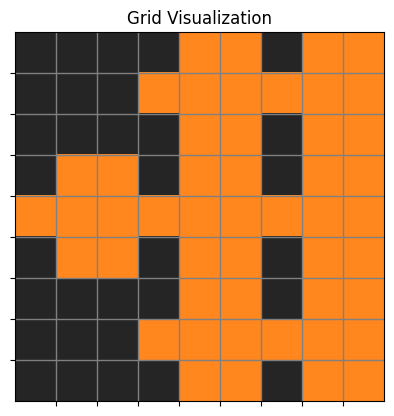

In [57]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# Your grid data
grid = [[7, 0, 7], 
        [7, 0, 7], 
        [7, 7, 0]]

grid = training_challenges.get("007bbfb7").get("train")[0].get("output")

colors = [
    '#252525', # black
    '#0074D9', # blue
    '#FF4136', # red
    '#37D449', #2ECC40', # green
    '#FFDC00', # yellow
    '#E6E6E6', # grey
    '#F012BE', # pink
    '#FF871E', # orange
    '#54D2EB', #7FDBFF', # light blue
    '#8D1D2C', #870C25', # brown
    '#FFFFFF'
]

# Convert to numpy array
grid_array = np.array(grid)

# Create the plot
fig, ax = plt.subplots()
ax.imshow(grid_array, cmap=ListedColormap(colors=colors), vmin=0, vmax=len(colors)-1)

# Add gridlines only for the major ticks
ax.set_xticks(np.arange(0.5, len(grid) - 1, 1))
ax.set_yticks(np.arange(0.5, len(grid[0]) - 1, 1))
ax.grid(color='grey', linestyle='-', linewidth=1)

# Remove the tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.title('Grid Visualization')
plt.show()

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class FlexibleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super(FlexibleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x, target_size=None):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.conv3(x)
        
        if target_size:
            x = nn.functional.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
        
        return x

def prepare_grid(grid):
    return torch.tensor(grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

def predict(model, input_grid, target_size):
    model.eval()
    with torch.no_grad():
        input_tensor = prepare_grid(input_grid)
        output = model(input_tensor, target_size=target_size)
        predicted = torch.argmax(output, dim=1)
    return predicted.squeeze().numpy()

def adapt_and_predict(model, example_inputs, example_outputs, test_input, num_adaptation_steps=100, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for step in range(num_adaptation_steps):
        total_loss = 0
        for inp, out in zip(example_inputs, example_outputs):
            optimizer.zero_grad()
            input_tensor = prepare_grid(inp)
            target_tensor = torch.tensor(out, dtype=torch.long).unsqueeze(0)
            output = model(input_tensor, target_size=target_tensor.shape[1:])
            
            loss = criterion(output, target_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if step % 10 == 0:
            print(f'Step [{step}/{num_adaptation_steps}], Loss: {total_loss / len(example_inputs):.4f}')

    target_size = torch.tensor(example_outputs[0]).unsqueeze(0).shape[1:]
    return predict(model, test_input, target_size=target_size)

model = FlexibleCNN(num_classes=10)

def adapt_and_predict_on_question(question_key):
    print("Running", question_key)
    example_inputs = [pair["input"] for pair in training_challenges.get(question_key).get("train")]
    example_outputs = [pair["output"] for pair in training_challenges.get(question_key).get("train")]
    test_input = training_challenges.get(question_key).get("test")[0].get("input")
    print("inputs", example_inputs)
    print("outputs", example_outputs)
    print("test", test_input)

    # Adapt and predict
    prediction = adapt_and_predict(model, example_inputs, example_outputs, test_input)
    print(f"Prediction for test {question_key}:")
    print(prediction)
    

for key in ['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c', '0520fde7', '05269061']:
    adapt_and_predict_on_question(key)
    

Running 007bbfb7
inputs [[[0, 7, 7], [7, 7, 7], [0, 7, 7]], [[4, 0, 4], [0, 0, 0], [0, 4, 0]], [[0, 0, 0], [0, 0, 2], [2, 0, 2]], [[6, 6, 0], [6, 0, 0], [0, 6, 6]], [[2, 2, 2], [0, 0, 0], [0, 2, 2]]]
outputs [[[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]], [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 2], [2, 0, 2, 0, 0, 0, 2, 0, 2]], [[